In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import torch

In [4]:
import os
os.chdir("/content/drive/MyDrive")
!ls

 AI-molecular.gslides
 Assignment_4
 bert-base-cased_final_results.csv
 chehreh.jpg
'Colab Notebooks'
 data.csv
 distilroberta-base_final_results.csv
'GAN _LSGAN.ipynb'
 HW3.gdoc
'Image Captioning Using Encoder-Decoder Architecture.ipynb'
 Interview.gdoc
 kaggle.json
 KARTMELI.jpg
 MIMICaccess.gdoc
 nesha
 NLPudemy
'out1 (1).xls'
 out1_sareh.csv
 P1830603-1.jpg
 pic080.jpg
 pic081.jpg
 professions.json
 Report.docx
 roberta-base_final_results.csv
 roberta-large_final_results.csv
 Robotics1.rar
 scan005.jpg
 shenasname.jpg
 SKMBT_C35113090707481_0001.jpg
 sop1.docx
 sop-changes.gdoc
 sss111_0003.jpg
 STAT.rar
'To-do list.gsheet'
'Unified, Real-Time Object Detection (YOLO).ipynb'
 untitled4.py
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document.gdoc'
'Untitled presentation.gslides'


In [5]:
df = pd.read_csv('out1_sareh.csv')
df

,paragraph_index,paragraph,sentence,label
0,0,"['1)', '2) EGD this am, continue octreotide g...","No tremors, no H/A, Alert and oriented, plea...",[1]
1,1,"['1)', '2) altered mental status, anticholine...","In the ED, he was reportedly combative, irri...",[2]
2,2,['1) Flolan at 15ng/kg/min (based on 95kg mai...,Anxiety Assessment:,[1]
3,3,"['1) Events:', '2) Moderate amount of bleedi...",Fentanyl w/ facial grimacing with trach car...,[1]
4,4,"['1) Assessed mental status.', '2) Reoriente...",No change in mental status.,[1]
...,...,...,...,...
553,546,"['1)', '2) BS being monitored, regular insuli...",*] Left leg pain with grimacing and yelling ...,[1]
554,547,"['1)', '2) th 100 mcg boluses every [', '3) ...","Subsequently, on Saturday afternoon [**10-6*...",[1]
555,548,"[""1) PRBC's with a repeat"", '2) Hct-33.6 (28...",pt had a profound episode of agitation requ...,[1]
556,549,"['1)', '2) s/', '3) p L: hip repair.', '4) ...","Pt intermittently confused,attempting to get...",[1]


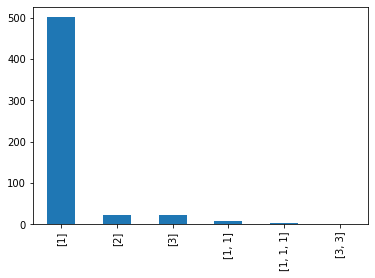

In [6]:
#check the distribution of sentiment classes across our data.

df['label'].value_counts().plot(kind='bar')

In [7]:
text = df['sentence'][0]
text

'  No tremors, no H/A, Alert and oriented, pleasant and cooperative,  following all commands, denies anxiety, denies hallucinations, no  sweating noted, lethargic following dilaudid dose, CIWA,<10  Action:  Assessed for signs of DTs, freq.'

In [8]:
labels = df['label'].values
type((labels))
sentiment = []
for label in labels:
  label = label.replace( "[" , "")
  label = label.replace("]" , "")
  label = label.replace(",", "")
  sentiment.append(label)
s = [s[:2] for s in sentiment] 
sentiments = [int(i) for i in s]

In [10]:
import numpy as np
#sentiments.count().plot(kind='bar')

In [11]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 35.4 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
#model_name = 'Emran/ClinicalBERT_ICD10_Full'
model_name = 'AndyJ/clinicalBERT'

In [13]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name)


Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [14]:
from transformers import BertTokenizer

tokeniser = BertTokenizer.from_pretrained(model_name)

tokens = tokeniser(df['paragraph'].tolist(), max_length= 512, padding = 'max_length', truncation = True,
                      add_special_tokens = True, return_tensors = 'pt' )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [15]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
text_IDs = tokens.input_ids
text_mask = tokens.attention_mask

In [17]:
text_IDs

tensor([[ 101, 1031, 1005,  ...,    0,    0,    0],
        [ 101, 1031, 1005,  ...,    0,    0,    0],
        [ 101, 1031, 1005,  ...,    0,    0,    0],
        ...,
        [ 101, 1031, 1000,  ...,    0,    0,    0],
        [ 101, 1031, 1005,  ...,    0,    0,    0],
        [ 101, 1031, 1005,  ...,    0,    0,    0]])

In [18]:
sentiments= torch.tensor(sentiments).unsqueeze(dim=1)
sentiments.shape

torch.Size([558, 1])

In [19]:
text_IDs.shape

torch.Size([558, 512])

In [20]:
from torch.utils.data import TensorDataset, DataLoader

In [21]:
dataset = TensorDataset(text_IDs, text_mask, sentiments)

In [22]:
batch_size = 16
split = 0.9
size = text_IDs.shape[0]
train_size = int(size/batch_size * split)
val_size = len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size , val_size])

In [23]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle= True, drop_last= True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle= True, drop_last= True)

In [24]:
class Clinicalbert(torch.nn.Module):
  def __init__(self):

    super(Clinicalbert, self).__init__()
  #transformer
    self.hidden_states = BertForSequenceClassification.from_pretrained(model_name)
  #clasification heads
    self.layer1 = torch.nn.Linear(768, 3)
  #prob
    self.prob = torch.nn.Softmax(dim = 1)

  def forward(self, text_IDs, attention_mask):

    embeddings = self.hidden_states(text_IDs, attention_mask)[1] #get the pooled output
    print(embeddings.shape)
    z = self.layer1(embeddings[:0]) #get the cls vector
    output= self.prob(z)
    return output



In [25]:
if torch.cuda.is_available():
  device  = torch.device("cuda")
else:
  device = torch.device("cpu")

In [26]:
model= Clinicalbert()
model.to(device)

Clinicalbert(
  (hidden_states): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [27]:
criterian =torch.nn.CrossEntropyLoss()
optimiser = torch.optim.AdamW(params = model.parameters() , lr = 5e-3)

In [28]:
def evaluate(model,dataloader, device):

    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    criterion = torch.nn.CrossEntropyLoss()

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'token_type_ids':batch[2],
        }
        with torch.no_grad():
            outputs = model(**inputs)

        targets = batch[3].to(device, dtype=torch.long)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        logits = outputs.data
        logits = logits.detach().cpu().numpy()
        label_ids = batch[3].cpu().numpy()
        predictions.append(logits)
        true_labels.append(label_ids)

    loss_avg = total_loss / len(dataloader)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    return loss_avg, predictions, true_labels

In [29]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [30]:
from tqdm import tqdm

In [31]:
epoch = 5
for i in range(5):
  model.train()
  for iterarion, data in tqdm(enumerate(train_loader, 0)):
    ids = data[0].to(device)
    attention = data[1].to(device)
    targets = data[2].to(device)
    out = model (ids, attention)
    loss = criterian(labels, out)
    if iterarion % 100 == 0:
        valid_loss, predictions_valid, true_valid = evaluate(model, val_loader, device)
        valid_f1 = f1_score_func(predictions_valid, true_valid)
        train_loss, predictions_train, true_train = evaluate(model, train_loader, device)
        train_f1 = f1_score_func(predictions_train, true_train)
        print("\nf1 score on valid data is: ", valid_f1)
        print("\nf1 score on train data is: ", train_f1)



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  torch.save(model.state_dict(), f'ClinicalBert_epoch{i}.model')

0it [00:00, ?it/s]


RuntimeError: ignored

In [ ]:
outputs = model (**tokens)

In [ ]:
outputs

In [ ]:
outputs.logits.shape


In [ ]:
#etract the logit tensor
outputs[0]

In [ ]:
import torch.nn.functional as F
probs = F.softmax(outputs[0], dim = -1)
probs

In [ ]:
import torch
pred = torch.argmax(probs)
pred.item()